# Demonstration of the use of machine learning models in IDS

# Introduction

This project is an investigation into how machine learning techniques can be used for intrusion detection systems (IDS's). I'm using the NSL-KDD dataset to train differnet models, and I'll evaluate the performance of different models.

To define the problem more specifically, I'm looking to classify different network traffic into either normal or different malicious categories depending on different features. This type of problem is a supervised machine learning problem, with labelled data being used to train machine learning models.

## The Dataset

### Imports

In [11]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_kddcup99
from sklearn.model_selection import train_test_split

#loading bar!!! B)
from tqdm import tqdm

#packages required for imputing values
from sklearn.impute import SimpleImputer
#one hot encoding
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

import seaborn as sns


In [12]:
# Load the dataset

feature_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate", "class", 'difficulty level']

dataset = pd.read_csv("NSL-KDD/KDDTrain+.txt", names = feature_names)
test_dataset = pd.read_csv("NSL-KDD/KDDTest+.txt", names = feature_names)

In [13]:
print(len(test_dataset.keys()))
print(len(dataset.keys()))
print(len(dataset['class']))

43
43
125973


### Dataset analysis

The NSL-KDD dataset contains 41 features for each data entry, and a label specifying if the network traffic is normal, or a specific type of attack.
Below is a list of the features used to predict the classes:

In [80]:
names = "Features: "
for name in feature_names:
    names = names + name + ", "

print(names)

Features: duration, protocol_type, service, flag, src_bytes, dst_bytes, land, wrong_fragment, urgent, hot, num_failed_logins, logged_in, num_compromised, root_shell, su_attempted, num_root, num_file_creations, num_shells, num_access_files, num_outbound_cmds, is_host_login, is_guest_login, count, srv_count, serror_rate, srv_serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate, dst_host_count, dst_host_srv_count, dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate, dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate, class, difficulty level, 


And below is a breakdown of the proportions of different classes present in the dataset:

['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster']


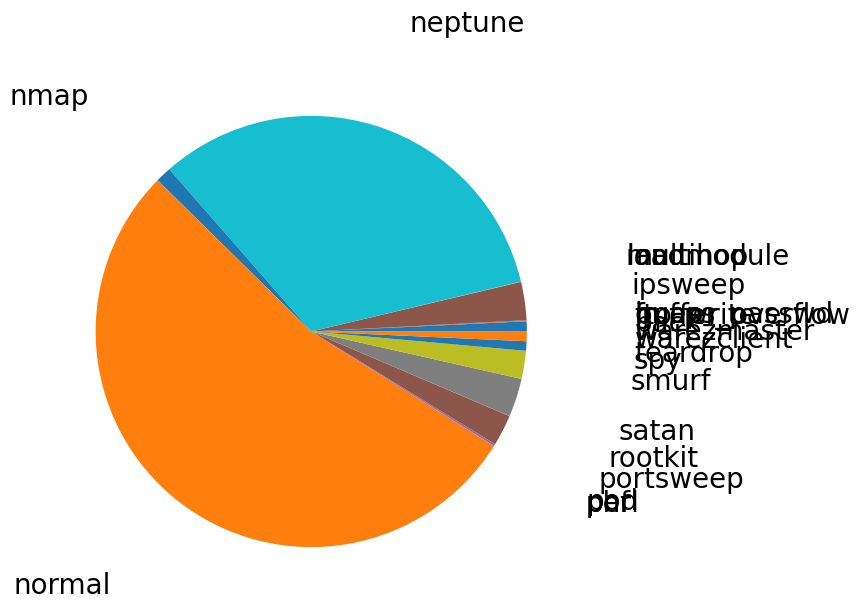

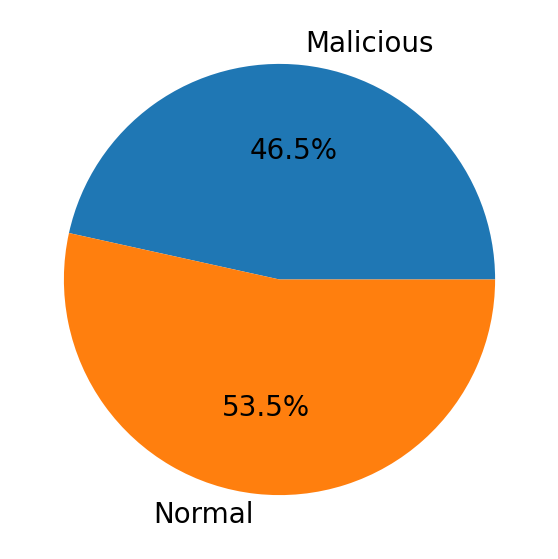

In [14]:
unique_classes = np.unique(dataset['class'])
print(unique_classes)
counts = []
plt.rcParams['font.size'] = 20

for unique_class in unique_classes:
    counts.append(int(np.count_nonzero(dataset['class'] == unique_class)))

# showing more detailed different types of traffic
plt.figure(figsize=(7, 7))
plt.pie(counts, labels=unique_classes, labeldistance=1.5)
plt.show()



# showing malicious or normal traffic
normal_count = np.count_nonzero(dataset['class'] == 'normal')
plt.figure(figsize=(7, 7))
plt.pie([len(dataset['class']) - normal_count, normal_count], autopct='%1.1f%%', labels=['Malicious', 'Normal'])
plt.show()



As is shown by the pie charts above, most of the network traffic in the dataset is of smurf attacks.

Smurf attacks are DDOS attacks where large numbers of ICMP packets with the victims IP address spoofed are broadcast to a computer network using an IP broadcast address. Most devices on the network will by default respond to the source IP address, flooding the victim with traffic.

The second largest type of network attack is a neptune attack, which is an attack that exploits the flaws in the three-way-handshake TCP protocol. Large numbers of spoofed SYN packets are sent directly toward a TCP server with a spoofed IP address, causing the TCP server to send back SYN/ACK packets and wait for the ACK packets, but the attacker doesn't respond. This causes the TCP server to reject any new connections.


# Data preprocessing

To improve the performance of the dataset, I have performed pre-processing on the dataset. I have:
1. *Encoded categorical features*: Encoded categorical features such as the protocol type using one hot encoding.
2. *Normalise features*: Since many of the features have different ranges, I have scaled them to the same range to avoid over-prominence of certain features
3. *Deal with missing values*: I have dealt with any missing values by either deleting columns that have a significant number of values missing, or replacing the missing values. This is only necessary for some machine learning algorithms however.
4. *Change data structure*: I have changed the data structure from a dictionary to a numpy array to make processing by the model easier

## Chaning the data structure

In [15]:
def reformat_data(data):
    """
    Takes the dictionary containing data and converts it
    to numpy arrays
    :param feature: data to be reformatted
    :returns: numpy array of x and y
    """
    x = []

    for name in feature_names:

        if name != 'class' and name != 'difficulty level':
            x.append(data[name])
    
    x = np.array(x).T
    y = np.array(data['class'])
    
    return x, y 

## One hot encoding

This transforms catergorical data into binary features that can be processed by machine learning algorithms. It works by adding features for each category, then flagging the feature that represents which category the data point is in.

In [16]:
def perform_one_hot_encoding(features):
    """
    Performs one hot encoding on an array of categorical features
    :param feature: column to be encoded
    :returns: categorical column encoded as integer columns
    """
    feature_length = len(features)
    features = np.expand_dims(features, axis=0).T
    encoder = OneHotEncoder()
    encoded_features = encoder.fit_transform(features)
    feature_labels = encoder.categories_[0].tolist()
    return encoded_features.toarray().T, feature_labels

## Normalising features

In [17]:
def rescale_features(features):
    """
    Rescales continuous and discrete features to be between 0 and 1
    :param feature: column to be rescaoed
    :returns: column rescaled between 0 and 1
    """
    # if array is all zeros don't divide by zero obviously
    if(np.linalg.norm(features) == 0):
        return features
   
    return features/np.linalg.norm(features)

## Imputing missing values

Replaces the missing values with the mean or median of the other data points, or in the case of the categorical data with the most frequent. Using a more complex imputer such as KNN might improve performance but this is a to do.

In [18]:
def impute_missing_values(features, impute_strategy):
    """
    Imputes missing values with either median or mean
    :param features: features with missing values
    :param use_median: if set to false, the mean is used
     to replace missing values instead of the median
    :returns: features without missing values
    """
    feature_length = len(features)
    # sci-kits simpleimputer needs reshaping for it to work for some reason
    features = np.expand_dims(features, axis=0)
    imputer = SimpleImputer(missing_values=np.nan, strategy=impute_strategy)
    imputed_features = np.array(imputer.fit_transform(features))
    return imputed_features.reshape(feature_length)

## Full pre-processing

In [19]:
def pre_process_data(data, impute_strategy='mean'):
    """ 
    Takes in a raw dataset and processes it to be used by
    machine learning models
    """

    category_labels = []
    processed_data = []

    if data.ndim == 2:
        # transposing data so it can be manipulated column-wise
        transposed_data = data.T
        transposed = True
    else:
        transposed_data = np.array([data])
        transposed = False

    i = 0
    # processing each column independently
    for column in tqdm(transposed_data):
        if type(column[0]) != int and type(column[0]) != float:
            column = impute_missing_values(column, 'most_frequent')
            
            columns, category_label = perform_one_hot_encoding(column)
            
            for category in category_label:
                category_labels.append(category)

            for column in columns:
                processed_data.append(column)
        
        else:
            column = impute_missing_values(column, impute_strategy)
            column = rescale_features(column)
            processed_data.append(column)
            category_labels.append(feature_names[i])
        
        i += 1

    processed_data = np.array(processed_data)
        
    # turning the array back to a numpy array and transposing it
    # to return it to the correct shape
    processed_data = np.array(processed_data).T
    return processed_data, np.array(category_labels).flatten()


### Processing training and testing data

In [20]:
x_train, y_train = reformat_data(dataset)
x_test, y_test = reformat_data(test_dataset)
train_length = len(x_train)

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
print(f'Processing features...')
x, x_labels = pre_process_data(x)
print(f'Processing labels...')
y, y_labels = pre_process_data(y)

print("X labels: ", x_labels)
print("Y labels: ", y_labels)

x_train = x[:train_length]
y_train = y[:train_length]

x_test = x[train_length:]
y_test = y[train_length:]

print(f'\nTrainining - Features shape: {x_train.shape} \nLabels shape: {y_train.shape}')
print(f'\nTesting - Features shape: {x_test.shape} \nLabels shape: {y_test.shape}')

Processing features...


100%|██████████| 41/41 [00:01<00:00, 25.41it/s]


Processing labels...


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

X labels:  ['duration' 'icmp' 'tcp' 'udp' 'IRC' 'X11' 'Z39_50' 'aol' 'auth' 'bgp'
 'courier' 'csnet_ns' 'ctf' 'daytime' 'discard' 'domain' 'domain_u' 'echo'
 'eco_i' 'ecr_i' 'efs' 'exec' 'finger' 'ftp' 'ftp_data' 'gopher' 'harvest'
 'hostnames' 'http' 'http_2784' 'http_443' 'http_8001' 'imap4' 'iso_tsap'
 'klogin' 'kshell' 'ldap' 'link' 'login' 'mtp' 'name' 'netbios_dgm'
 'netbios_ns' 'netbios_ssn' 'netstat' 'nnsp' 'nntp' 'ntp_u' 'other'
 'pm_dump' 'pop_2' 'pop_3' 'printer' 'private' 'red_i' 'remote_job' 'rje'
 'shell' 'smtp' 'sql_net' 'ssh' 'sunrpc' 'supdup' 'systat' 'telnet'
 'tftp_u' 'tim_i' 'time' 'urh_i' 'urp_i' 'uucp' 'uucp_path' 'vmnet'
 'whois' 'OTH' 'REJ' 'RSTO' 'RSTOS0' 'RSTR' 'S0' 'S1' 'S2' 'S3' 'SF' 'SH'
 'src_bytes' 'dst_bytes' 'land' 'wrong_fragment' 'urgent' 'hot'
 'num_failed_logins' 'logged_in' 'num_compromised' 'root_shell'
 'su_attempted' 'num_root' 'num_file_creations' 'num_shells'
 'num_access_files' 'num_outbound_cmds' 'is_host_login' 'is_guest_login'
 'count' 'sr

# Training the models

Training time! I've broken down the various models I've used into different sections.

Below I've got a couple imports for the models I'm using.

In [21]:
# model imports

# random forest
from sklearn.ensemble import RandomForestClassifier


# SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# tensorflow
import tensorflow as tf

##  Random Forest Classifier

To start off with, I'm using a random forest classifier to categorise the network traffic. Random forests build on [decision trees](https://en.wikipedia.org/wiki/Decision_tree_learning), by taking random samples to create more decision trees, of which the average classification can then be taken. Decision trees are effectively a lot of if statements which can be optimised by maximising [information gain](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). 

Training:

In [22]:
# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=200, max_depth=5)

# Fit the classifier to the training data
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=200)

Testing:

In [23]:
# Make predictions on the test data
rf_predictions = rf.predict(x_test)

print('Random Forest Classifier performance: ' + str(100*accuracy_score(y_test, rf_predictions)) + "%")

Random Forest Classifier performance: 67.80074520936836%


## Support Vector Machine (Binary Classification)

Second up is a support vector machine. Without getting too specific, the idea behind a support vector machine is to find a [hyperplane](https://en.wikipedia.org/wiki/Hyperplane) that separates a set of data points into two classes. The hyperplane is found my maximising the margin between the nearest data points and the hyperplane. The nearest data points are called support vectors, hence they are called support vector machines.

As I mentioned, support vector machines in their simplest form do binary classification, so I'll only be classifying between normal and malicious network traffic.

In [24]:
y_train_binary = y_train[:, 16]
y_test_binary = y_test[:, 16]


In [25]:
svc_model = SVC()
#SVMs are only binary classifiers so I've reduced the output from normal 
svc_model.fit(x_train, y_train_binary)

SVC()

In [26]:
svm_predictions = svc_model.predict(x_test)

In [27]:

print('SVM performance: ' + str(100*accuracy_score(y_test_binary, svm_predictions)) + "%")

SVM performance: 78.4332860184528%


## Neural Network

Neural networks in machine learning are like Messi in Inter Miami. You're not there to see the rest of the team. Anyway, since its obligatory for this project to include one, I'm repeating the same classification task as I did for the Random Forest Classifier, so I can tell people I'm very clever and that I used neural networks. I'm going to be honest, we didn't really cover this stuff in huge detail in my first year at uni, so this is me trying my best at something I've never done before.

I'm using tensorflow to generate the model, and I've tuned the number of layers and neurons per layer a bit but they're not optimal. Behold:

In [28]:
# modifying the way the outputs work because the neural network will output an integer classification instead of one hot encoding

def one_hot_encoding_to_integer_classification(data):
    """ 
    Tranforms data encoded in one hot encoding and changes
    it to be encoded in integers
    :param data: data to be encoded
    :returns: encoded data
    """
    print(data.shape)
    output = np.zeros((len(data)))

    for i in range(len(output)):
        output[i] = np.where(data[i] == 1)[0]

    return output

nn_y_train = one_hot_encoding_to_integer_classification(y_train)
print(nn_y_train[0])

(125973, 40)
16.0


In [83]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(len(x_train[0]), activation='sigmoid'),
  tf.keras.layers.Dense(len(x_train[0]), activation='sigmoid'),
  tf.keras.layers.Dense(len(x_train[0]), activation='sigmoid'),
  tf.keras.layers.Dense(len(y_train[0]))
])             

In [84]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [85]:
print(f'X shape: {x_train.shape}, Y_train shape: {y_train.shape}')

model.fit(x_train, nn_y_train, epochs=10)

X shape: (125973, 122), Y_train shape: (125973, 40)
Epoch 1/10
3937/3937 [==============================] - 4s 880us/step - loss: 8.8754 - accuracy: 0.5339
Epoch 2/10
3937/3937 [==============================] - 3s 779us/step - loss: 8.8863 - accuracy: 0.5346
Epoch 3/10
3937/3937 [==============================] - 3s 823us/step - loss: 8.8864 - accuracy: 0.5346
Epoch 4/10
3937/3937 [==============================] - 3s 798us/step - loss: 8.8863 - accuracy: 0.5346
Epoch 5/10
3937/3937 [==============================] - 3s 783us/step - loss: 8.8863 - accuracy: 0.5346
Epoch 6/10
3937/3937 [==============================] - 3s 863us/step - loss: 8.8863 - accuracy: 0.5346
Epoch 7/10
3937/3937 [==============================] - 3s 834us/step - loss: 8.8863 - accuracy: 0.5346
Epoch 8/10
3937/3937 [==============================] - 3s 883us/step - loss: 8.8863 - accuracy: 0.5346
Epoch 9/10
3937/3937 [==============================] - 3s 854us/step - loss: 8.8863 - accuracy: 0.5346
Epoch 10/10


In [71]:
nn_y_test = one_hot_encoding_to_integer_classification(y_test)
test_loss, test_accuracy = model.evaluate(x_test, nn_y_test, verbose=2)
print('\n Test accuracy:', test_accuracy)

(22544, 40)
705/705 - 0s - loss: 10.2351 - accuracy: 0.4308 - 343ms/epoch - 487us/step

 Test accuracy: 0.43075764179229736


Inconviently, tensorflow doesn't output its results in the same way that sklearn does for the other two models, so the rest of the code below converts the outputs into a form we'll want for the further performance anaylsis ahead.

In [73]:
def transform_to_arrays(integers):
    result = []
    print(integers)
    for integer in integers:
        temp = np.zeros((len(y_labels)))
        temp[int(integer)] = 1
        result.append(temp)
    return np.array(result)

In [74]:
# running this for performance evaluations later
nn_output = model.predict(x_test)
nn_predictions = np.zeros(len(nn_output))
i = 0

for i in range(len(nn_output)):
    
    nn_predictions[i] = np.argmax(nn_output[i])
    if nn_predictions[i] > len(y_labels):
        print('ues')
    i += 1


nn_predictions = transform_to_arrays(nn_predictions)


705/705 [==============================] - 0s 343us/step
[16. 16. 16. ... 16. 16. 16.]


# Performance results in more detail

First lets take a look at the distribution of classes between the testing and training data. This will help us understand the performance of the models.

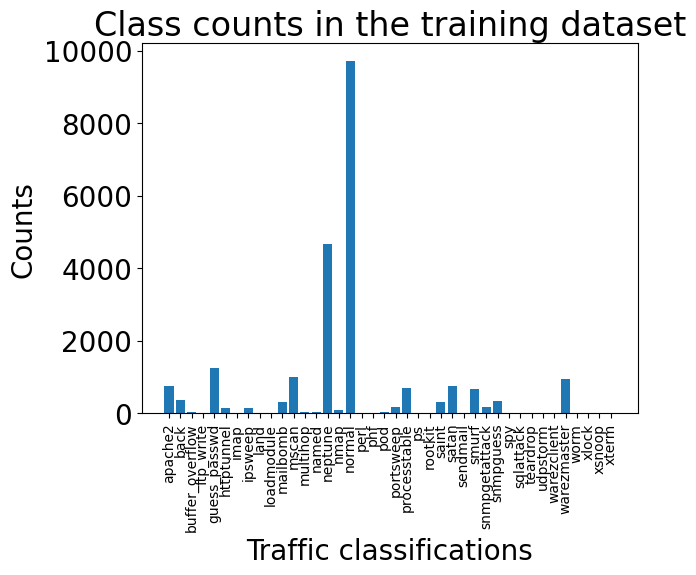

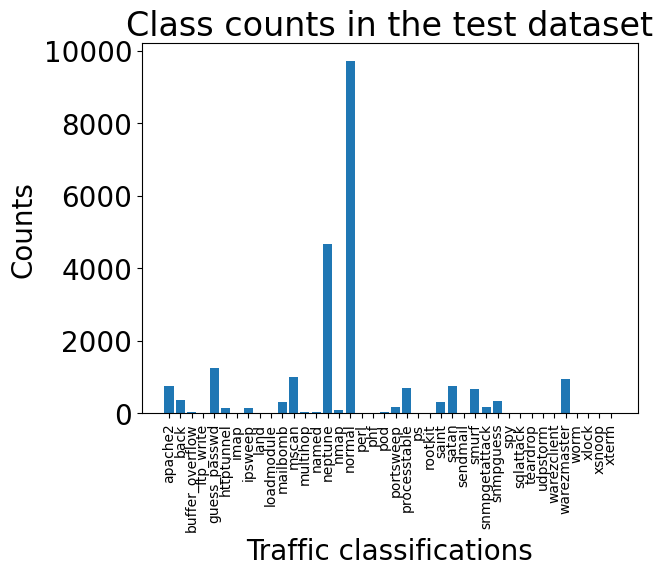

In [35]:
y_class_sums = np.sum(y_test, axis=0)
x_class_sums = np.sum(x_test, axis=0)
data = []

# training data bar graph
plt.bar(y_labels, y_class_sums)

plt.xlabel('Traffic classifications')
plt.ylabel('Counts')
plt.title('Class counts in the training dataset')
plt.xticks(rotation=90, fontsize=10)

plt.show()


# testing data bar graph
plt.bar(y_labels, y_class_sums)

plt.xlabel('Traffic classifications')
plt.ylabel('Counts')
plt.title('Class counts in the test dataset')
plt.xticks(rotation=90, fontsize=10)

plt.show()


We can see that the test dataset isn't completely exhaustive, there are a lot of classes which are either zero in either of the datasets or are way too small to appear on our visualisations, we could remove these to improve performance, but I'm taking the route of less friction and we can see how this impacts the performance of the models.

## Support Vector Machine

Let's start with the support vector machine (SVM) model we trained. We used this model to classify the data into two classes, normal and malicious. I've decided to make a confusion matrix that can both give us insights into the model's performance and the choices the model is making. Below is a function to create a confusion matrix for our support vector machine.

In [36]:
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(matrix_title, classes, y_true, y_pred,):
    """
    Generates a confusion matrix for a model's predictions
    :param graph_title: Title of the confusion matrix
    :param labels: Labels of the classes
    :param predictions: predictions made by the model
    :param target: what the model is aiming to predict
    """

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=matrix_title,
           ylabel='Actual labels',
           xlabel='Predicted labels')

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Now let's run this function on the predictions made by our model.

<Axes: title={'center': 'Support Vector Machine'}, xlabel='Predicted labels', ylabel='Actual labels'>

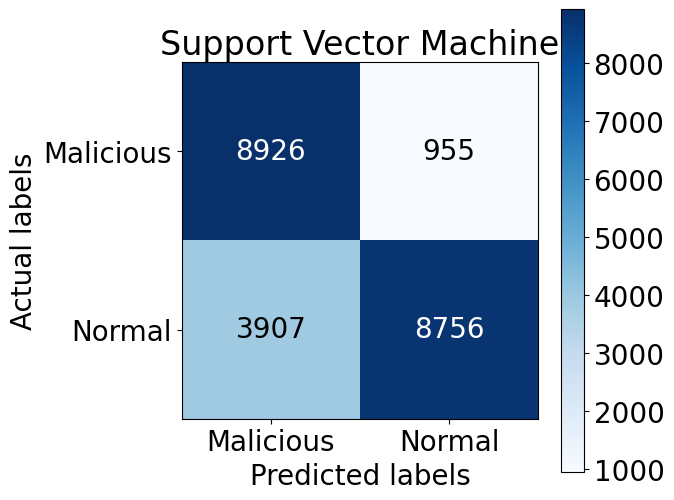

In [37]:
generate_confusion_matrix("Support Vector Machine", ["Malicious", "Normal"], svm_predictions, y_test_binary)

We can see our SVM classifies malicious data and normal data as normal most of the time, by the large numbers in the top left and bottom right quadrants. However, we already knew the model performs well, by the 78.4% accuracy earlier in the notebook. What's more interesting to find out is where the model is going wrong. We can see the bottom left quadrant, representing when the model misclassifies normal data as malicious has a count of 3907, whereas the top right quadrant, where the model misclassifies malicious data as normal has a count of 955. While the model is misclassifying both ways, this suggests the model is being slightly too harsh on the data, classifying more normal traffic as malicious than it should be. In the context of an IDS, this is better than letting more malicious traffic through.

# Random Forest Classifier

The random forest classifier mainly differs from the support vector machine in the fact that it is classifying into multiple classes rather than just two classes. To accomodate for this, I've rewritten the function to generate our confusion matrix (or heatmap) for our multiple classes.

In [62]:
from sklearn.metrics import multilabel_confusion_matrix
from collections import Counter

def plot_multilabel_confusion_matrix(y_true, y_pred, classes, title='', log_counts=False):

    # Assuming y_pred and y_true are your predicted and true label arrays
    # Assuming num_classes is the number of classes/categories in your data
    num_classes = len(y_pred[0])

    # adding one for the np.log function
    data = np.ones((num_classes, num_classes), dtype=int)

    for i in (range(len(y_pred))):
        pred_indices = np.where(y_pred[i] == 1)[0]  # Indices of predicted labels
        true_indices = np.where(y_true[i] == 1)[0]  # Indices of true labels

        # Update the confusion matrix using Counter for efficient counting
        counter = Counter(zip(pred_indices, true_indices))
        for (x, y), count in counter.items():
            data[x][y] += count
    
    if log_counts:
        print('Logging values...')
        data = np.log(data)
        print('Done logging values')
    
    plt.figure(figsize=(15,15))
    
    ax = sns.heatmap(data, xticklabels=classes, yticklabels=classes, cbar=True, cmap="YlGnBu")
    plt.title(title)
    ax.set_xlabel("True network classifications")
    ax.set_ylabel("Predicted network classifications")

    plt.show()


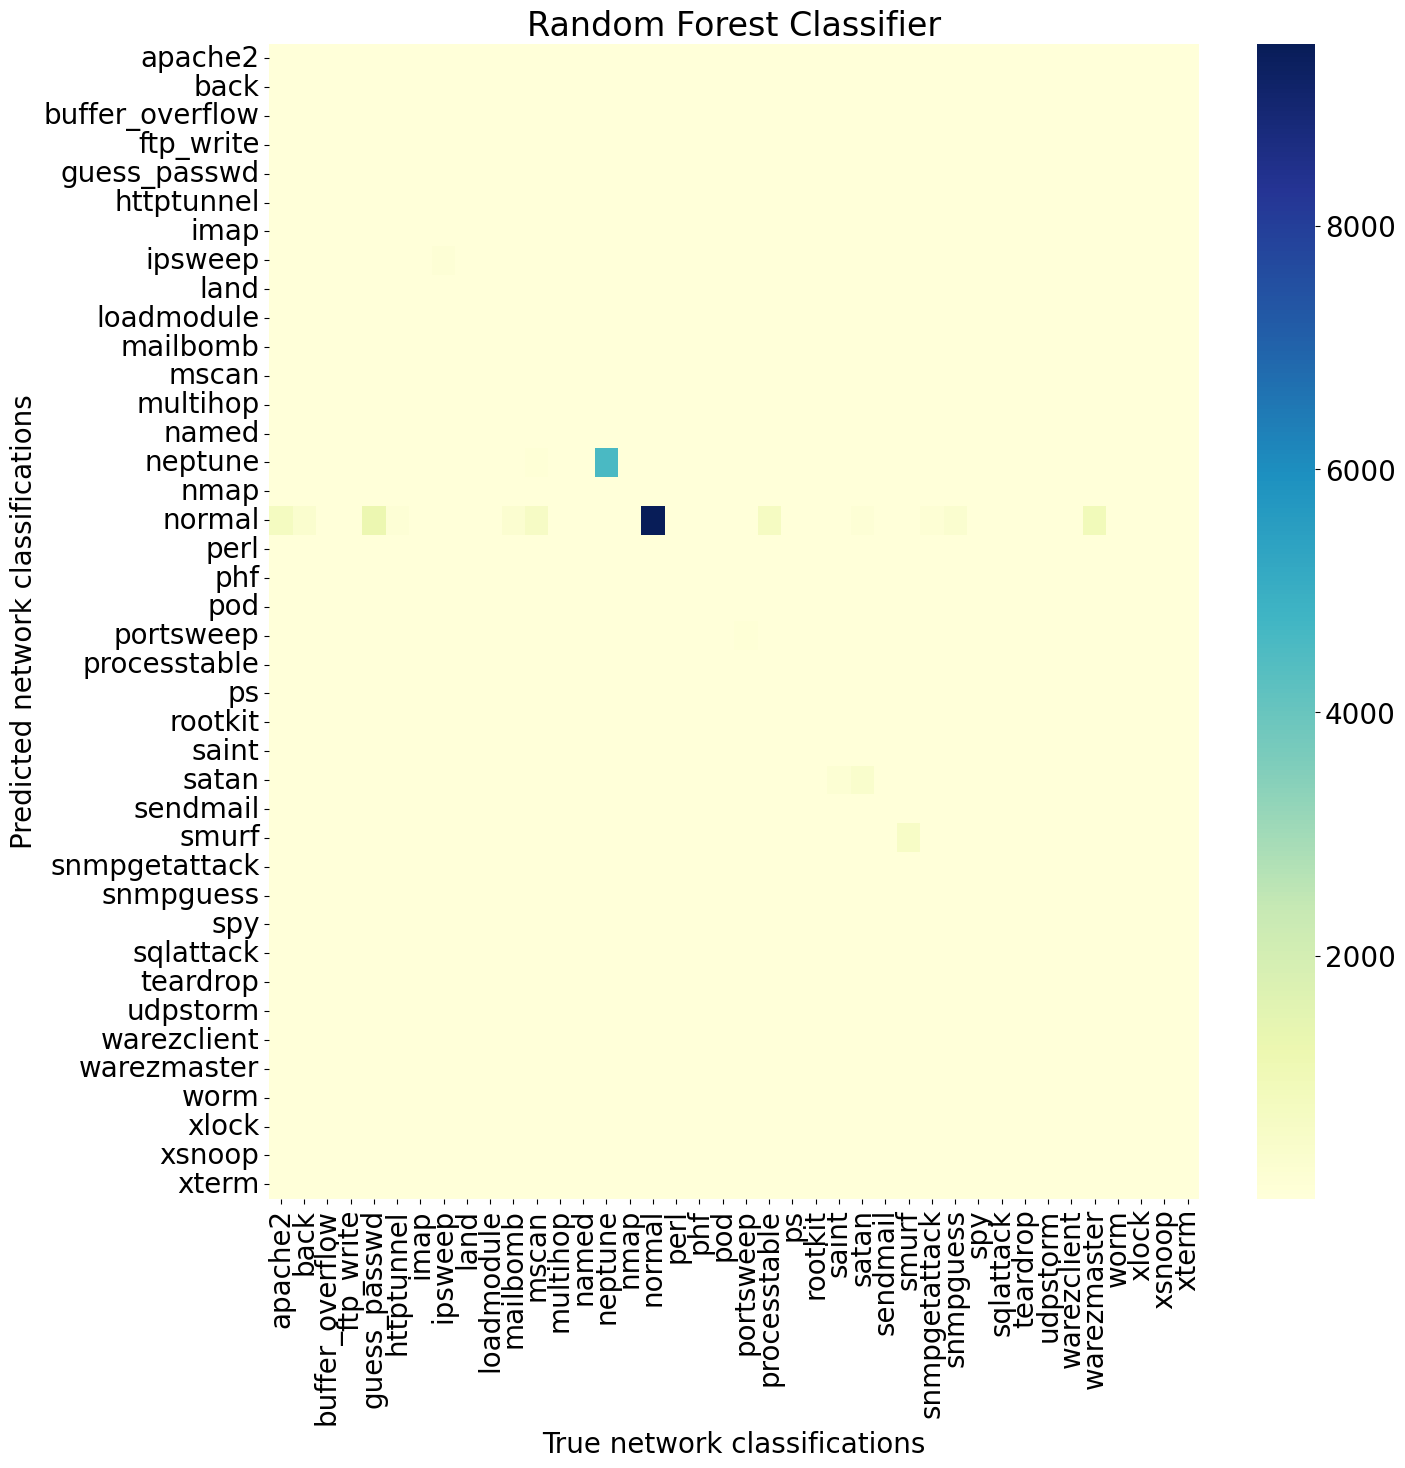

In [63]:
plot_multilabel_confusion_matrix(y_test, rf_predictions, y_labels, 'Random Forest Classifier')

It's pretty hard to see what's going on here, since there are a lot more 'normal' datapoints than any other ones. To make it more readable, lets perform the log function on the data values. 

Logging values...
Done logging values


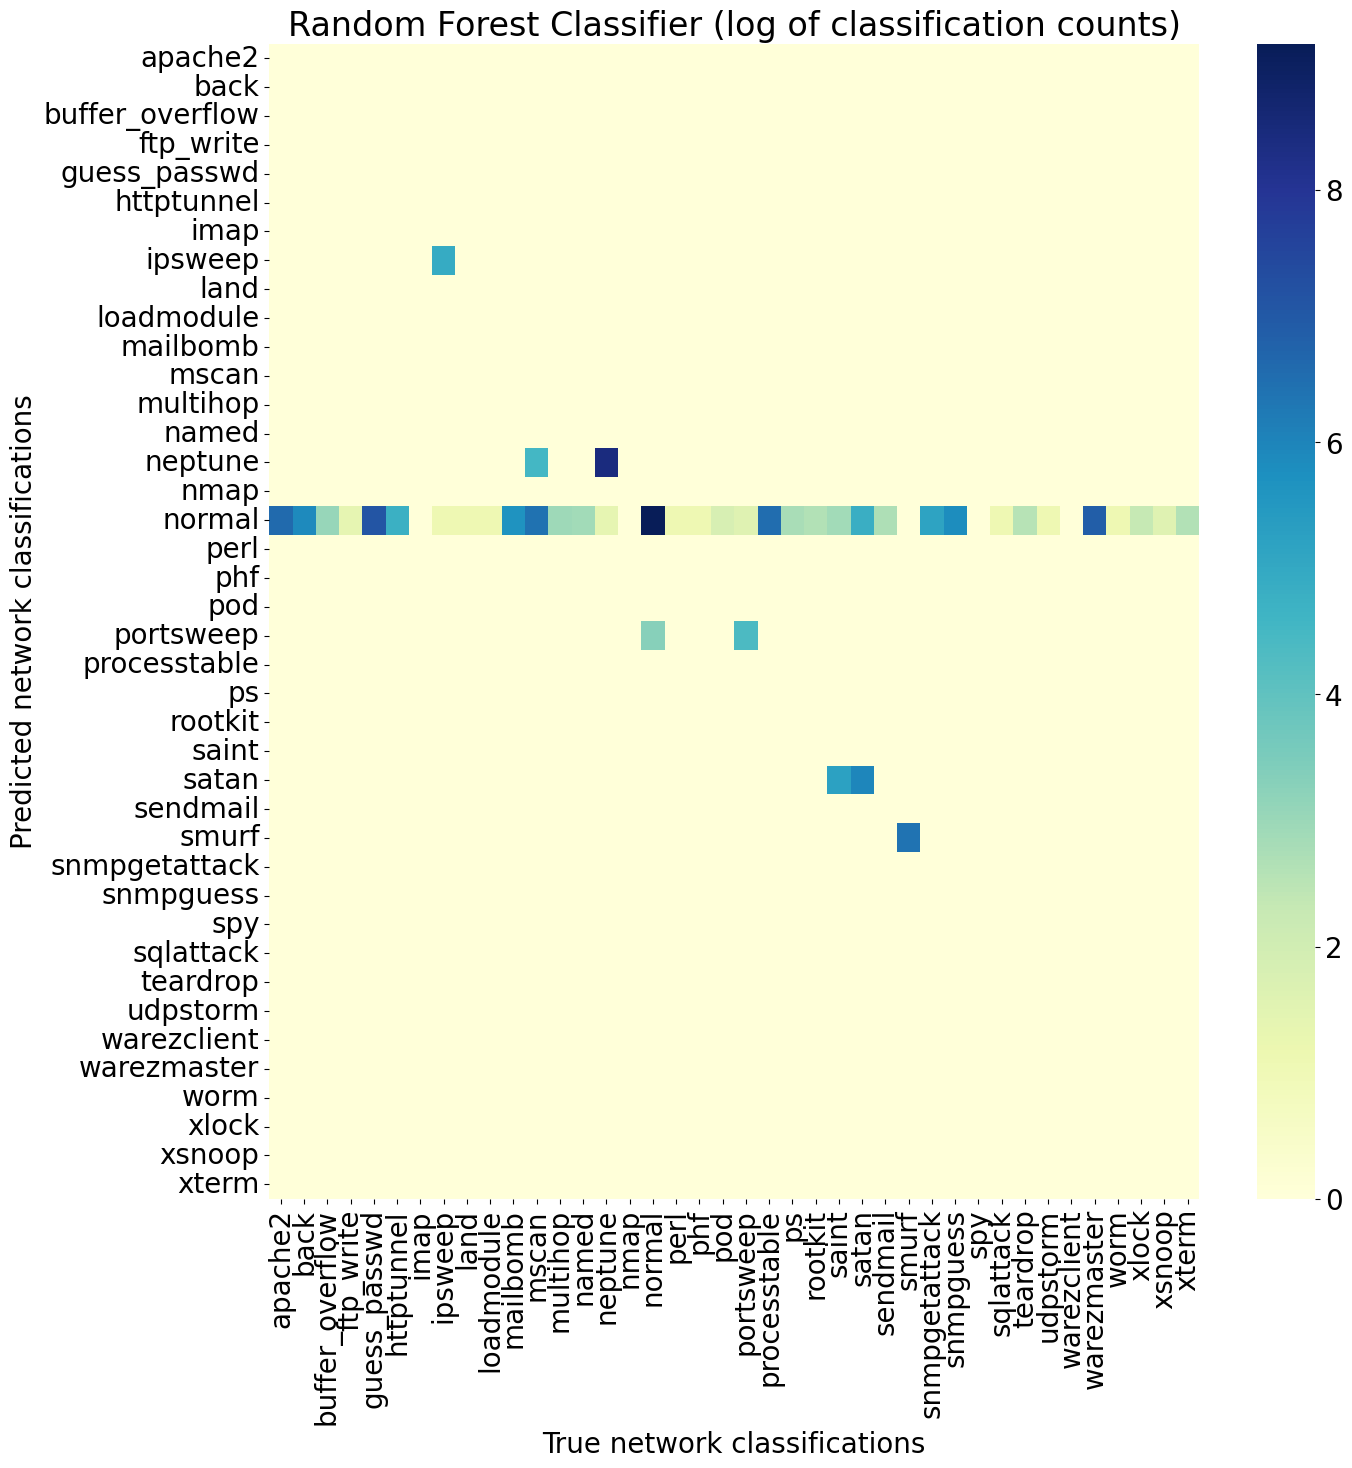

In [65]:
plot_multilabel_confusion_matrix(y_test, rf_predictions, y_labels, 'Random Forest Classifier (log of classification counts)', log_counts=True)

The visualation here is a bit more complicated than what we used withe SVM, but its fundamentally showing the data in the same way. Along the bottom, there is each true classification, and up the right is the predicted classifications by our model. We can see that the data along the true network classifications axis (horizontal), is spread out across the matrix. Constrasting to this, the predicted classifications are more or less completely centered on the normal classification, aside from a few classes such as ipsweep, neptune and satan. This shows to us that our Support Vector Machine is overclassifying traffic as normal. Apart from the obvious fact that it's far from ideal for an IDS system to be labelling dangerous network data as malicious, its interesting to note why this is happening.

Looking at the dataset, its clear that the proportion of normal traffic in the training data is much higher than the other classes. Generally, this is bad for training as it can skew the model's learning, in the exact way as we see here. As they say, [RIRO](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out).

## Neural Network

Like the support vector machine, the neural network outputs more than just 2 classes, so we can just reuse the function we used for the SVM to generate the heatmap. 

Logging values...
Done logging values


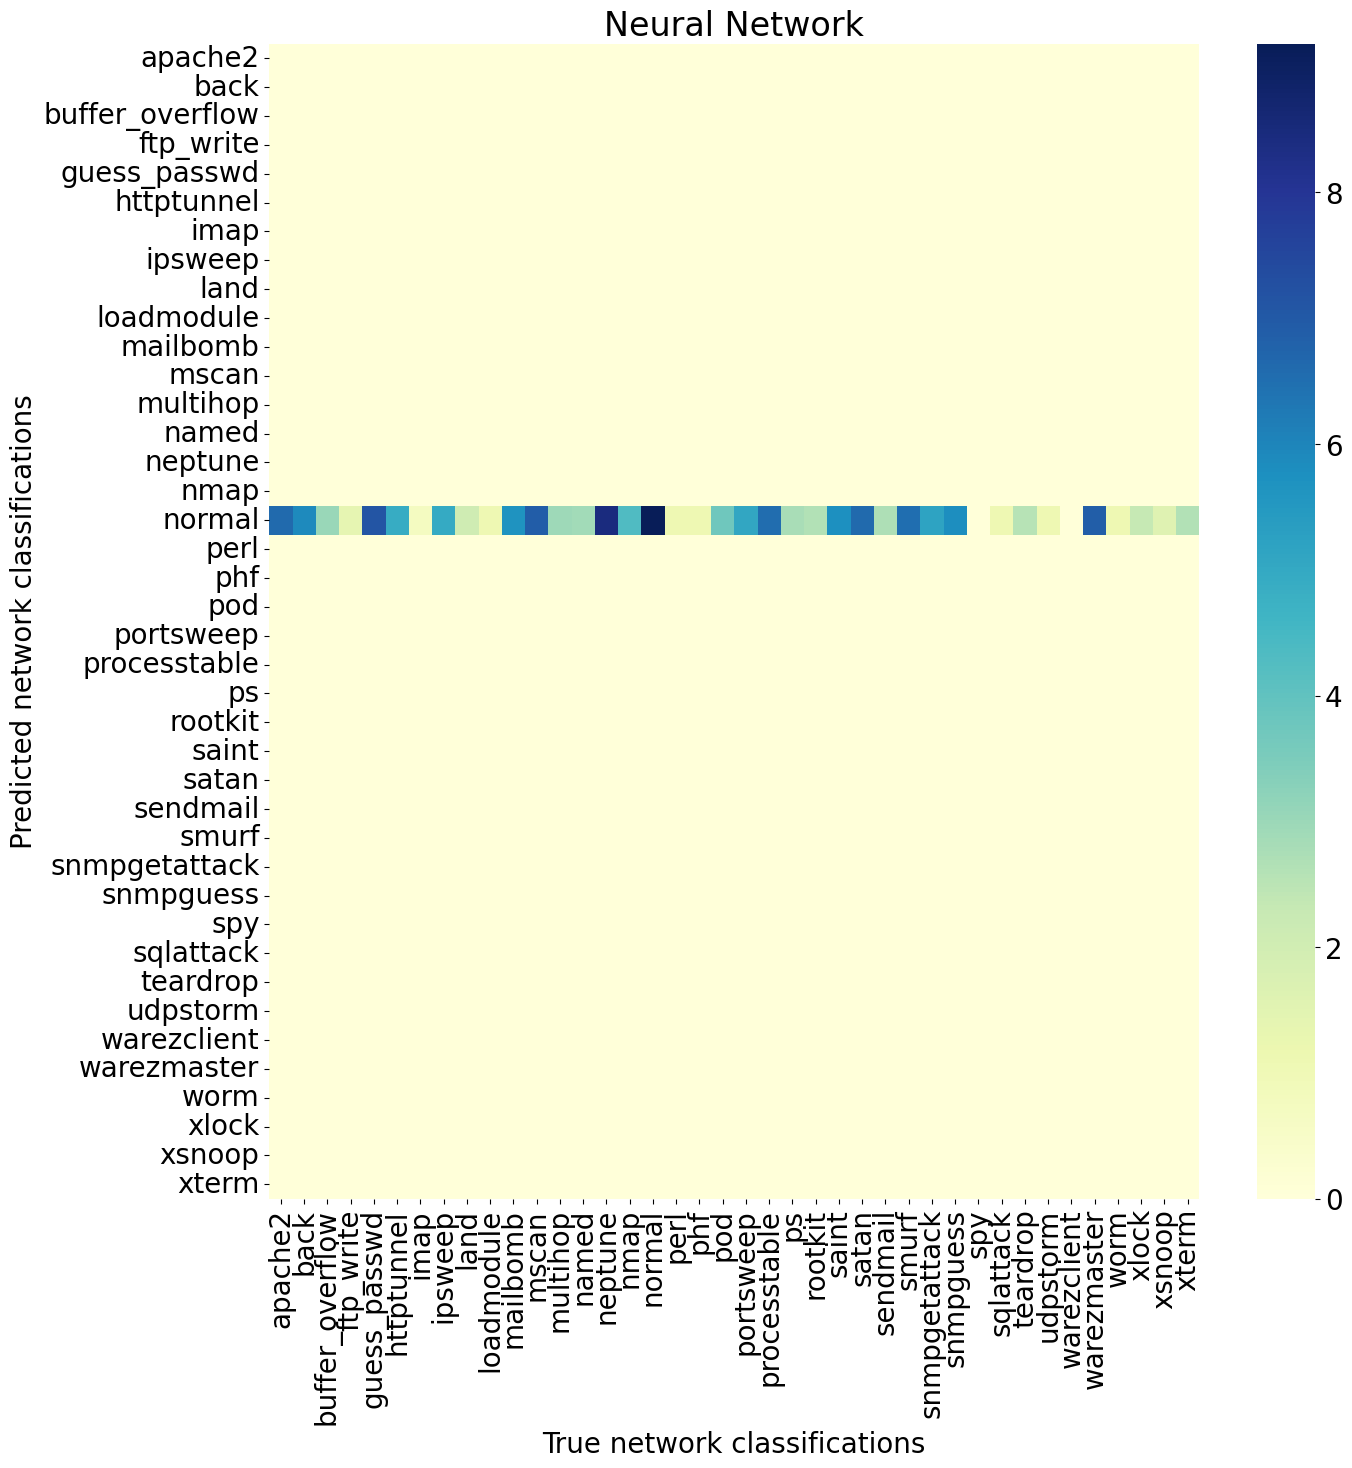

In [75]:
plot_multilabel_confusion_matrix(y_test, nn_predictions, y_labels, 'Neural Network', log_counts=True)


This matrix clearly shows that our tensorflow neural network is only selecting the neptune class. Why? I'm not sure, it's not even the most common class, which is what I might expect. Nonetheless, tensorflow does not care what I expect, and does it anyway. It's possible there's a bug in my code, or the size and irregularity might be throwing it off. Either way, debugging tensorflow code is beyond the aims of this project given time constraints.

# Conclusion

This project has been fun and I've learned a lot of things about network security and machine learning. I've learned about different machine learning techniques, and also methods of visualising data and model performance. It's also been interesting to note the effects of having a slightly skewed dataset.

None of the models performed to a point where you could ever use them as an IDS and have any confidence in your network security, unless you removed any network adapters from the said machine and sealed it shut in a lead lined container. However, I have both learned about and demonstrated my understanding of how supervised machine learning can be used in the field of cybersecurity, which has been a very interesting investigation.